# Breast cancer detection from thermal imaging

The main purpose of this project is to develop a comprehensive decision support system for breast cancer screening.

## Library import
In this section, the libraries that will be used throughout this model will be imported. Keep in mind that part of the libraries used by this program are declared in the files found in `src/scripts/*.py`.

In [1]:
# Modules are reloaded automatically before entering the execution of code throughout this notebook
%reload_ext autoreload
%autoreload 2

In [2]:
from scripts import *

In [3]:
computer.check_available_devices(ignore=True) # Check available devices

Available devices:
- CPU: /physical_device:CPU:0


## Data selection
To make this model work correctly it will be necessary to extract and save the images found in the `data` folder.

In this folder there are two labeled folders that contain all the images to be used:
```
data
├── healthy
└── sick
```

In [4]:
data_path = "./data/"
output_path = "./output/"
random_state = 42

In [5]:
data = Data(data_path) # Data imported into a table

data.images.head(3) # Display first 3 rows

,image,category
0,./data/healthy/16-TFRON_V16_31-10-2012_8.jpg,0
1,./data/healthy/169-TFRON_V173_8-4-2013_0.jpg,0
2,./data/healthy/17-TFRON_V17_31-10-2012_6.jpg,0


## Transformation
In the transformation stage, the data is adapted to find the solution to the problem to be solved.

First of all, the data obtained previously will be divided to be able to use it for training and to check the results.

In [6]:
data.training, data.test = data.train_test_split(test_size=0.15, random_state=random_state, stratify=True) # Split data into train and test

In [7]:
# The category distribution is shown for the original, training, and test data
data.count_labels(data.images, "Original")
data.count_labels(data.training, "Training")
data.count_labels(data.test, "Test")

Original: [99 96] [0.51 0.49]
Training: [84 81] [0.51 0.49]
Test: [15 15] [0.5 0.5]


### Creation of generators
Once the data is divided, different transformation techniques are applied on it to expand the size of the dataset in real time while training the model. To apply a correct solution to the problem, the training and validation dataset will be divided into k consecutive folds, while the test dataset will remain fixed.

In [8]:
training_validation_generator = data.training_validation_generator(n_splits=5, random_state=random_state) # Generate training and validation generators
test_generator = data.test_generator() # Generate test generator

Found 132 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.
Found 132 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


### Filter creation
Once the necessary generators have been created, the filters are created for their subsequent model training.

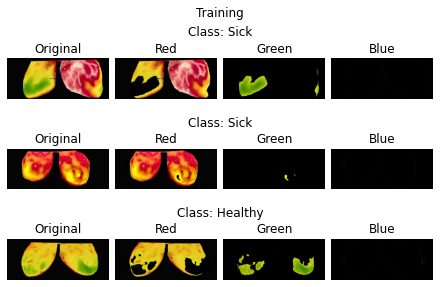

In [9]:
filters = {
	"original": lambda x: x,
	"red": lambda x: data.get_image_tensor(x, (330, 0, 0), (360, 255, 255)) + data.get_image_tensor(x, (0, 0, 0), (60, 255, 255)),
	"green": lambda x: data.get_image_tensor(x, (60, 0, 0), (130, 255, 255)),
	"blue": lambda x: data.get_image_tensor(x, (130, 0, 0), (330, 255, 255))
}

data.show_images(training_validation_generator[0][0], filters,  size=3, name="Training") # Show some images from the training generator

## Data Mining
This section seeks to apply techniques that are capable of extracting useful patterns and then evaluate them.

### Model creation
The model to be used for the next training is created.

In [12]:
red_model = Model(name="red", subfolder=f"state_{random_state}", filter=filters["red"]) # Red model creation

In [ ]:
red_model.compile() # Compile the red model
green_model.compile() # Compile the green model
blue_model.compile() # Compile the blue model

### Model training
The created model is trained indicating the times that are going to be used.

In [ ]:
red_model.fit(train_generator, validation_generator, epochs=600, verbose=False, plot=False) # Train the red model
green_model.fit(train_generator, validation_generator, epochs=600, verbose=False, plot=False) # Train the green model
blue_model.fit(train_generator, validation_generator, epochs=600, verbose=False, plot=False) # Train the blue model

### Model evaluation
The trained model is evaluated using the generators created before. In this case, the best weight matrix obtained in the training will be used.

In [ ]:
red_model.evaluate(train_generator, name="train_generator", path=None) # Evaluate the red model
red_model.evaluate(validation_generator, name="validation_generator", path=None) # Evaluate the red model
red_model.evaluate(test_generator, name="test_generator", path=None) # Evaluate the red model

In [ ]:
green_model.evaluate(train_generator, name="train_generator", path=None) # Evaluate the green model
green_model.evaluate(validation_generator, name="validation_generator", path=None) # Evaluate the green model
green_model.evaluate(test_generator, name="test_generator", path=None) # Evaluate the green model

In [ ]:
blue_model.evaluate(train_generator, name="train_generator", path=None) # Evaluate the blue model
blue_model.evaluate(validation_generator, name="validation_generator", path=None) # Evaluate the blue model
blue_model.evaluate(test_generator, name="test_generator", path=None) # Evaluate the blue model

### Obtaining the weighted average

The three models extracted above are combined to obtain, through the use of differential evolution, the optimal distribution of weights to obtain a future prediction.

In [ ]:
join_models = Join(red_model, green_model, blue_model) # Models are joined

In [ ]:
join_models.get_weighted_average(test_generator, iterations=100, tolerance=1e-7) # Compute the weighted average

In [ ]:
join_models.evaluate(test_generator, name="test_generator") # Evaluate the weighted average

### Grad-CAM
An activation map of the predictions obtained by the convolutional network is displayed.

In [ ]:
# The activation map is displayed
for index, image in data.test.iterrows():
	join_models.visualize_heatmap(image)